In [ ]:
fundo = 'mxrf11'
anos = ['2020','2021','2022' , '2023' , '2024']  # dados na CVM a partir de 2016

In [ ]:
#@markdown Dados de cnpj, copiei de uma pagina web da empiricus, não verifiquei, convem conferir

### pra esconder essa célula, clicar duas vezes na região do texto--->

import pandas as pd

cnpj_fii ={'CNPJ':  {'ABCP11': '01.201.140/0001-90','AFHI11': '36.642.293/0001-58',
  'AIEC11': '35.765.826/0001-26',  'ALMI11': '07.122.725/0001-00', 'ALZM11': '34.847.063/0001-08',  'ALZR11': '28.737.771/0001-85',
  'ANCR11B': '07.789.135/0001-27', 'APTO11': '42.432.327/0001-82', 'APXM11': '43.010.485/0001-07',  'AROA11': '44.674.528/0001-11',
  'ARRI11': '32.006.821/0001-21',  'ARXD11': '44.527.494/0001-32', 'ASMT11': '38.293.921/0001-62',  'ASRF11': '45.188.033/0001-45',
  'ATCR11': '14.631.148/0001-39',  'ATSA11': '12.809.972/0001-00', 'ATWN11': '27.773.327/0001-52',  'AURB11': '41.076.823/0001-88',
  'BARI11': '29.267.567/0001-00', 'BBFI11B': '07.000.400/0001-46', 'BBFO11': '37.180.091/0001-02',  'BBIM11': '20.716.161/0001-93',
  'BBPO11': '14.410.722/0001-29',  'BBRC11': '12.681.340/0001-04', 'BCFF11': '11.026.627/0001-38',  'BCIA11': '20.216.935/0001-17',
  'BCRI11': '22.219.335/0001-38',  'BICE11': '39.332.032/0001-20', 'BICR11': '34.007.109/0001-72',  'BIME11': '41.081.356/0001-84',
  'BIPD11': '42.869.892/0001-01',  'BLCA11': '41.076.748/0001-55', 'BLMC11': '38.294.221/0001-92',  'BLMG11': '34.081.637/0001-71',
  'BLMO11': '34.895.894/0001-47',  'BLMR11': '36.368.869/0001-30', 'BLUR11': '38.051.307/0001-94',  'BMII11': '02.027.437/0001-44',
  'BMLC11': '14.376.247/0001-11',  'BNFS11': '15.570.431/0001-60', 'BPFF11': '17.324.357/0001-28',  'BPLC11': '28.267.555/0001-13',
  'BPML11': '33.046.142/0001-49',  'BPRP11': '29.800.650/0001-01', 'BRCO11': '20.748.515/0001-81',  'BRCR11': '08.924.783/0001-01',
  'BREV11': '26.195.121/0001-20',  'BRHT11B': '15.461.076/0001-91', 'BRIM11': '23.964.843/0001-03',  'BRIP11': '34.895.752/0001-80',
  'BRIX11': '35.360.651/0001-77',  'BRLA11': '35.652.278/0001-28', 'BROF11': '48.978.859/0001-04',  'BRSE11': '40.944.736/0001-32',
  'BTAL11': '36.642.244/0001-15',  'BTCI11': '09.552.812/0001-14', 'BTLG11': '11.839.593/0001-09',  'BTRA11': '41.076.607/0001-32',
  'BTSG11': '36.098.375/0001-83',  'BTSI11': '36.930.464/0001-44', 'BTWR11': '20.132.453/0001-89',  'BVAR11': '21.126.204/0001-43',
  'BZEL11': '35.507.610/0001-60',  'BZLI11': '14.074.706/0001-02', 'CACR11': '32.065.364/0001-46',  'CARE11': '13.584.584/0001-31',
  'CBOP11': '17.144.039/0001-85',  'CCLB11': '45.777.347/0001-83', 'CCME11': '43.010.844/0001-26',  'CCRF11': '40.011.268/0001-43',
  'CEOC11': '15.799.397/0001-09',  'CFHI11': '34.508.923/0001-70', 'CFII11': '41.325.993/0001-59',  'CIXR11': '47.086.230/0001-89',
  'CJCT11': '10.347.985/0001-80',  'CJFI11': '23.582.914/0001-03', 'CNES11': '13.551.286/0001-45',  'COPP11': '48.916.699/0001-60',
  'CPFF11': '34.081.611/0001-23',  'CPFO11': '48.916.246/0001-34', 'CPSH11': '47.896.665/0001-99',  'CPTS11': '18.979.895/0001-13',
  'CRFF11': '31.887.401/0001-39',  'CSMC11': '41.081.336/0001-03', 'CTXT11': '00.762.723/0001-28',  'CVBI11': '28.729.197/0001-13',
  'CVPR11': '38.294.329/0001-85',  'CXAG11': '40.189.596/0001-34', 'CXCE11B': '10.991.914/0001-15', 'CXCI11': '42.066.916/0001-94',
  'CXCO11': '38.658.984/0001-75',  'CXRI11': '17.098.794/0001-70', 'CXTL11': '12.887.506/0001-43',  'CYCR11': '36.501.233/0001-15',
  'CYLD11': '43.010.601/0001-98', 'DAMT11B': '26.642.727/0001-66', 'DEVA11': '37.087.810/0001-37',  'DLMT11': '28.108.193/0001-18',
  'DOVL11B': '10.522.648/0001-81', 'DPRO11': '42.922.127/0001-08', 'DRIT11B': '10.456.810/0001-00', 'DVFF11': '39.863.059/0001-49',
  'EDFO11B': '06.175.262/0001-73', 'EDGA11': '15.333.306/0001-37', 'EGYR11': '36.969.658/0001-53', 'ELDO11B': '13.022.994/0001-99',
  'EQIR11': '41.076.380/0001-25',  'ERCR11': '37.266.902/0001-84', 'ERPA11': '31.469.385/0001-64',  'ESTQ11': '18.497.672/0001-10',
  'EURO11': '05.437.916/0001-27',  'EVBI11': '34.691.520/0001-00', 'EXES11': '41.076.851/0001-03',  'FAED11': '11.179.118/0001-45',
  'FAGL11': '29.614.033/0001-03', 'FAMB11B': '05.562.312/0001-02', 'FARU11': '47.240.652/0001-67',  'FATN11': '30.567.216/0001-02',
  'FCFL11': '11.602.654/0001-01',  'FGPM11': '23.781.227/0001-17', 'FIGS11': '17.590.518/0001-25',  'FIIB11': '14.217.108/0001-45',
  'FIIP11B': '08.696.175/0001-97', 'FINF11': '18.369.510/0001-04', 'FISC11': '12.804.013/0001-00',  'FISD11': '16.543.270/0001-89',
  'FIVN11': '17.854.016/0001-64',  'FLCR11': '33.884.145/0001-51', 'FLMA11': '04.141.645/0001-03',  'FLRP11': '10.375.382/0001-91',
  'FMOF11': '01.633.741/0001-72',  'FPAB11': '03.251.720/0001-18', 'FPNG11': '17.161.979/0001-82',  'FRHY11': '41.251.077/0001-11',
  'FTCE11B': '01.235.622/0001-61', 'FVPQ11': '00.332.266/0001-31', 'GALG11': '37.295.919/0001-60',  'GAME11': '41.269.052/0001-45',
  'GCFF11': '35.652.154/0001-42',  'GCOI11': '46.285.299/0001-79', 'GCRI11': '38.293.897/0001-61', 'GESE11B': '17.007.528/0001-95',
  'GGRC11': '26.614.291/0001-00',  'GSFI11': '11.769.604/0001-13', 'GTLG11': '36.200.677/0001-10',  'GTWR11': '23.740.527/0001-58',
  'GURB11': '36.501.210/0001-00',  'GVBI11': '49.581.652/0001-56', 'GZIT11': '15.447.108/0001-02',  'HAAA11': '27.445.482/0001-40',
  'HABT11': '30.578.417/0001-05',  'HBCR11': '36.501.159/0001-37', 'HBRH11': '30.871.698/0001-81',  'HBTT11': '26.846.202/0001-42',
  'HCHG11': '34.508.959/0001-54',  'HCRI11': '04.066.582/0001-60', 'HCST11': '31.152.015/0001-07',  'HCTR11': '30.248.180/0001-96',
  'HDEL11': '44.514.162/0001-13',  'HDOF11': '35.688.460/0001-39', 'HFOF11': '18.307.582/0001-19',  'HGBS11': '08.431.747/0001-06',
  'HGCR11': '11.160.521/0001-22',  'HGFF11': '32.784.898/0001-22', 'HGIC11': '38.456.508/0001-71',  'HGLG11': '11.728.688/0001-47',
  'HGPO11': '11.260.134/0001-68',  'HGRE11': '09.072.017/0001-29', 'HGRS11': '41.922.239/0001-04',  'HGRU11': '29.641.226/0001-53',
  'HILG11': '34.867.728/0001-37',  'HLOG11': '27.486.542/0001-72', 'HOFC11': '31.894.369/0001-19',  'HOSI11': '34.081.631/0001-02',
  'HPDP11': '35.586.415/0001-73',  'HRDF11': '16.929.519/0001-99', 'HREC11': '35.507.262/0001-21',  'HSAF11': '35.360.687/0001-50',
  'HSLG11': '32.903.621/0001-71',  'HSML11': '32.892.018/0001-31', 'HSRE11': '08.098.114/0001-28',  'HTMX11': '08.706.065/0001-69',
  'HUCG11': '39.347.413/0001-82',  'HUSC11': '28.851.767/0001-43', 'HUSI11': '30.017.492/0001-99',  'IBCR11': '40.011.251/0001-96',
  'IDFI11': '32.774.914/0001-04',  'IRDM11': '28.830.325/0001-10', 'IRIM11': '41.076.564/0001-95',  'ITIP11': '36.312.772/0001-06',
  'ITIT11': '36.293.425/0001-83',  'JASC11': '40.886.241/0001-02', 'JBFO11': '36.615.915/0001-59',  'JCDA11': '31.772.231/0001-47',
  'JCDB11': '35.705.542/0001-44',  'JFLL11': '36.501.181/0001-87', 'JPPA11': '30.982.880/0001-00',  'JPPC11': '17.216.625/0001-98',
  'JRDM11': '14.879.856/0001-93',  'JSAF11': '42.085.661/0001-07', 'JSRE11': '13.371.132/0001-71',  'JTPR11': '23.876.086/0001-16',
  'KCRE11': '42.502.802/0001-40',  'KEVE11': '32.317.313/0001-64', 'KFOF11': '30.091.444/0001-40',  'KINP11': '24.070.076/0001-51',
  'KISU11': '36.669.660/0001-07',  'KIVO11': '42.273.325/0001-98', 'KNCR11': '16.706.958/0001-32',  'KNHF11': '42.754.342/0001-47',
  'KNHY11': '30.130.708/0001-28',  'KNIP11': '24.960.430/0001-13', 'KNPR11': '42.737.059/0001-07',  'KNRE11': '14.423.780/0001-97',
  'KNRI11': '12.005.956/0001-65',  'KNSC11': '35.864.448/0001-38', 'LASC11': '30.248.158/0001-46', 'LATR11B': '17.209.378/0001-00',
  'LAVF11': '37.467.733/0001-40',  'LFTT11': '24.796.967/0001-90', 'LGCP11': '34.598.181/0001-11',  'LIFE11': '39.753.295/0001-02',
  'LKDV11': '40.102.445/0001-05',  'LLAO11': '41.218.404/0001-33', 'LOFT11B': '19.722.048/0001-31', 'LPLP11': '37.262.752/0001-30',
  'LRDI11': '41.088.534/0001-07',  'LSPA11': '31.847.293/0001-70', 'LUGG11': '34.835.191/0001-23',  'LVBI11': '30.629.603/0001-18',
  'MALL11': '26.499.833/0001-32',  'MANA11': '42.888.583/0001-89', 'MATV11': '41.076.678/0001-35',  'MAXR11': '11.274.415/0001-70',
  'MCCI11': '23.648.935/0001-84',  'MCHF11': '36.642.139/0001-86', 'MCHY11': '36.655.973/0001-06',  'MFAI11': '32.397.369/0001-76',  'MFCR11': '45.403.337/0001-88',  'MFII11': '16.915.968/0001-88',
  'MGCR11': '35.652.204/0001-91',  'MGFF11': '29.216.463/0001-77', 'MGHT11': '34.197.776/0001-65',  'MGRI11': '41.320.997/0001-44',
  'MINT11': '19.872.887/0001-36',  'MMPD11': '41.080.968/0001-52', 'MMVE11': '41.251.337/0001-59',  'MOFF11': '31.508.219/0001-20',
  'MORC11': '40.102.474/0001-69',  'MORE11': '34.197.727/0001-22', 'MTOF11': '22.862.226/0001-34',  'MVFI11': '23.537.203/0001-17',
  'MXRF11': '97.521.225/0001-25',  'NAVT11': '35.652.252/0001-80', 'NCHB11': '18.085.673/0001-57',  'NCRI11': '40.041.603/0001-56',
  'NEWL11': '32.527.626/0001-47',  'NEWU11': '14.793.782/0001-78', 'NSLU11': '08.014.513/0001-63',  'NVHO11': '17.025.970/0001-44',
  'NVIF11B': '22.003.469/0001-17', 'OGHY11': '47.240.631/0001-41', 'ONEF11': '12.948.291/0001-23',  'OUFF11': '30.791.386/0001-68',
  'OUJP11': '26.091.656/0001-50',  'OULG11': '13.974.819/0001-00', 'OURE11': '28.516.650/0001-03',  'PABY11': '00.613.094/0001-74',
  'PATB11': '14.788.492/0001-36',  'PATC11': '30.048.651/0001-12', 'PATL11': '35.754.164/0001-99',  'PBLV11': '31.962.875/0001-06',
  'PCAS11': '24.514.406/0001-50',  'PEMA11': '34.736.510/0001-43', 'PLCR11': '32.527.683/0001-26',  'PLOG11': '36.501.198/0001-34',
  'PLRI11': '14.080.689/0001-16',  'PNDL11': '37.899.400/0001-90', 'PNLN11': '40.887.170/0001-54',  'PNPR11': '26.813.118/0001-22',
  'PNRC11': '46.157.348/0001-98',  'PORD11': '17.156.502/0001-09', 'PQAG11': '12.978.943/0001-72',  'PQDP11': '10.869.155/0001-12',
  'PRSN11B': '14.056.001/0001-62', 'PRSV11': '11.281.322/0001-72', 'PRZS11': '30.258.790/0001-70',  'PVBI11': '35.652.102/0001-76',
  'QAGR11': '32.754.734/0001-52',  'QAMI11': '32.400.264/0001-29', 'RBDS11': '11.945.604/0001-27',  'RBED11': '13.873.457/0001-52',
  'RBFF11': '17.329.029/0001-14',  'RBHG11': '30.647.758/0001-87', 'RBHY11': '37.899.479/0001-50',  'RBIR11': '31.161.410/0001-48',
  'RBLG11': '35.652.227/0001-04',  'RBOP11': '13.500.306/0001-59', 'RBRD11': '09.006.914/0001-34',  'RBRF11': '27.529.279/0001-51',
  'RBRI11': '32.441.656/0001-36',  'RBRL11': '35.705.463/0001-33', 'RBRM11': '26.314.437/0001-93',  'RBRP11': '21.408.063/0001-51',
  'RBRR11': '29.467.977/0001-03',  'RBRS11': '36.517.660/0001-91', 'RBRX11': '41.088.458/0001-21',  'RBRY11': '30.166.700/0001-11',
  'RBTS11': '29.299.737/0001-39',  'RBVA11': '15.576.907/0001-70', 'RBVO11': '15.769.670/0001-44',  'RCFA11': '27.771.586/0001-44',
  'RCFF11': '35.689.670/0001-41',  'RCKF11': '43.010.139/0001-29', 'RCRB11': '03.683.056/0001-86',  'RDPD11': '23.120.027/0001-13',
  'RECR11': '28.152.272/0001-26',  'RECT11': '32.274.163/0001-59', 'RECX11': '36.642.356/0001-76',  'REIT11': '16.841.067/0001-99',
  'RELG11': '37.112.770/0001-36',  'REON11': '20.173.064/0001-00', 'RFOF11': '34.027.774/0001-28',  'RINV11': '44.625.612/0001-45',
  'RMAI11': '17.374.696/0001-19',  'RNDP11': '15.394.563/0001-89', 'RNGO11': '15.006.286/0001-90',  'ROOF11': '38.456.598/0001-09',
  'RPRI11': '42.502.842/0001-91',  'RRCI11': '35.689.733/0001-60', 'RSPD11': '19.249.989/0001-08',  'RVBI11': '35.507.457/0001-71',
  'RZAK11': '36.642.219/0001-31',  'RZAT11': '28.267.696/0001-36', 'RZDM11': '45.742.247/0001-11',  'RZTR11': '36.501.128/0001-86',
  'SACL11': '41.833.927/0001-90',  'SADI11': '32.903.521/0001-45', 'SAIC11B': '17.311.079/0001-74', 'SALI11': '36.669.535/0001-05',
  'SARE11': '32.903.702/0001-71',  'SBCL11': '34.471.719/0001-22', 'SCPF11': '01.657.856/0001-05',  'SDIL11': '16.671.412/0001-93',
  'SEED11': '35.689.497/0001-81',  'SEQR11': '09.517.273/0001-82', 'SFND11': '09.350.920/0001-04', 'SHDP11B': '07.224.019/0001-60',
  'SHOP11': '22.459.737/0001-00',  'SHPH11': '03.507.519/0001-59', 'SHSO11': '44.527.168/0001-25',  'SIGR11': '40.011.324/0001-40',
  'SJAU11': '27.771.547/0001-47',  'SNCI11': '41.076.710/0001-82', 'SNEL11': '43.741.171/0001-84',  'SNFF11': '40.011.225/0001-68',
  'SNLG11': '40.041.711/0001-29',  'SOLR11': '22.169.671/0001-13', 'SPAF11': '18.311.024/0001-27',  'SPDE11': '43.741.150/0001-69',
  'SPMO11': '40.225.262/0001-79',  'SPTW11': '15.538.445/0001-05', 'SPVJ11': '27.538.422/0001-71',  'SPXS11': '43.010.543/0001-00',  'SRVD11': '38.082.796/0001-41',  'STRX11': '11.044.355/0001-07',
  'TCIN11': '34.197.700/0001-30',  'TCPF11': '26.990.011/0001-50', 'TELD11': '36.200.701/0001-11',  'TELM11': '45.188.099/0001-35',
  'TEPP11': '26.681.370/0001-25',  'TGAR11': '25.032.881/0001-53', 'TJKB11': '39.714.024/0001-48',  'TORD11': '30.230.870/0001-18',
  'TRNT11': '04.722.883/0001-02',  'TRXB11': '36.368.925/0001-37', 'TRXF11': '28.548.288/0001-52',  'TSER11': '34.847.042/0001-84',
  'TSNC11': '17.007.443/0001-07',  'URPR11': '34.508.872/0001-87', 'VCJR11': '32.400.250/0001-05',  'VCRI11': '41.081.374/0001-66',
  'VCRR11': '40.041.723/0001-53',  'VDSV11': '43.951.875/0001-81', 'VERE11': '08.693.497/0001-82',  'VGHF11': '36.771.692/0001-19',
  'VGIP11': '34.197.811/0001-46',  'VGIR11': '29.852.732/0001-91', 'VIDS11': '32.527.552/0001-49',  'VIFI11': '31.547.855/0001-60',
  'VILG11': '24.853.044/0001-22',  'VINO11': '12.516.185/0001-70', 'VISC11': '17.554.274/0001-25',  'VIUR11': '36.445.587/0001-90',
  'VJFD11': '15.489.509/0001-17',  'VLJS11': '13.842.683/0001-76', 'VLOL11': '15.296.696/0001-12',  'VOTS11': '17.870.926/0001-30',
  'VPSI11': '14.721.889/0001-00',  'VRTA11': '11.664.201/0001-00', 'VSEC11': '10.347.505/0001-80',  'VSHO11': '23.740.595/0001-17',
  'VSLH11': '36.244.015/0001-42',  'VTLT11': '27.368.600/0001-63', 'VTPA11': '21.500.481/0001-74',  'VTVI11': '21.500.514/0001-86',
  'VTXI11': '23.740.552/0001-31',  'VVPR11': '33.045.581/0001-37', 'VXXV11': '30.982.974/0001-89',  'WHGR11': '41.256.643/0001-88',
  'WPLZ11': '09.326.861/0001-39',  'WSEC11': '43.440.579/0001-16', 'WTSP11B': '28.693.595/0001-27', 'XBXO11': '36.814.809/0001-02',
  'XPCI11': '28.516.301/0001-91',  'XPCM11': '16.802.320/0001-03', 'XPHT11': '18.308.516/0001-63',  'XPIN11': '28.516.325/0001-40',
  'XPLG11': '26.502.794/0001-85',  'XPML11': '28.757.546/0001-00', 'XPPR11': '30.654.849/0001-40',  'XPSF11': '30.983.020/0001-90',
  'YUFI11': '36.445.551/0001-06',  'ZAVI11': '40.575.940/0001-23', 'ZIFI11': '35.820.768/0001-96'}}

cnpjFii = pd.DataFrame.from_dict(cnpj_fii)

In [ ]:
# cnpj fo fundo
cnpj=cnpjFii.loc[fundo.upper()].CNPJ
cnpj

'97.521.225/0001-25'

In [ ]:
import requests
import zipfile
from datetime import datetime

def baixar_e_extrair_zip(url, caminho_destino = '/content'):
  """
  Baixa um arquivo ZIP de uma URL e extrai os arquivos para
  um dirietorio (pasta) no caminho de destino.
  """
  resposta = requests.get(url, stream=True)
  resposta.raise_for_status()

  with open("arquivo.zip", "wb") as arquivo_zip:
    for pedaço in resposta.iter_content(chunk_size=1024):
      arquivo_zip.write(pedaço)

  with zipfile.ZipFile("arquivo.zip", 'r') as zip_ref:
    zip_ref.extractall(caminho_destino)

#-----------------------------------------------------------------------

def ler_arquivos_fii(arquivos, colunas, **kwargs):
  """
  Lê as colunas de interesse em arquivos CSV
  com informações de FIIs em um único DataFrame.
  """

  dfs = []  # Lista para armazenar os DataFrames de cada arquivo
  for arquivo in arquivos:
    df = pd.read_csv(arquivo, sep=';', usecols=colunas,  **kwargs)
    df['Valor_Patrimonial_Cotas'] = df['Valor_Patrimonial_Cotas'].astype(float)
    dfs.append(df)

  df_combinado = pd.concat(dfs, ignore_index=True)
  return df_combinado

#-----------------------------------------------------------------------

def data_mais_proxima(data_alvo, lista_datas):
  """
       A data em lista_datas mais próxima de data_alvo.
  """
  menor_diferenca = None
  data_mais_proxima = None
  for data in lista_datas:
    diferenca = abs(data_alvo - data.date())
    if menor_diferenca is None or diferenca < menor_diferenca:
      menor_diferenca = diferenca
      data_mais_proxima = data

  return data_mais_proxima

In [ ]:
# baixar dados da CVM
import os
dir = os.listdir('/content') # pega o conteudo da pasta '/content'
                             # se já baixou dados nessa, não precisar baixar de novo
for ano in anos:
  if f'inf_mensal_fii_complemento_{ano}.csv' not in dir:
    url = f'https://dados.cvm.gov.br/dados/FII/DOC/INF_MENSAL/DADOS/inf_mensal_fii_{ano}.zip'
    baixar_e_extrair_zip(url)

# ler dados da CVM
arquivos = [f'/content/inf_mensal_fii_complemento_{ano}.csv'  for ano in anos]
colunas = ['CNPJ_Fundo', 'Data_Referencia', 'Valor_Patrimonial_Cotas']
df_fii = ler_arquivos_fii(arquivos, colunas, parse_dates=['Data_Referencia'], encoding='latin-1')

# pegar só dados do fundo de interesse
dados = df_fii[df_fii['CNPJ_Fundo'] == cnpj][['Data_Referencia','Valor_Patrimonial_Cotas']].copy()
dados['Data_Referencia'] = pd.to_datetime(dados['Data_Referencia']).dt.date

In [ ]:
dados.head(3)

,Data_Referencia,Valor_Patrimonial_Cotas
6067,2020-01-01,10.086317
6068,2020-02-01,10.327085
6069,2020-03-01,10.250717


In [ ]:
# baixar dados preço do pregão
import yfinance as yf
dados_yf = yf.download(fundo+'.SA')[['Adj Close']]

[*********************100%%**********************]  1 of 1 completed


In [ ]:
'''
  Nas datas de referência pode nao ter tido pregão
  Nesse caso, pego o valor do papel na data mais proxima
'''
preco = []
for dia in dados['Data_Referencia'].values:
  data_cota = data_mais_proxima(dia, dados_yf.index).date()
  preco.append(dados_yf.loc[data_cota.strftime('%Y-%m-%d')]['Adj Close'])
dados['preco'] = preco

In [ ]:
dados.head(3)

,Data_Referencia,Valor_Patrimonial_Cotas,preco
6067,2020-01-01,10.086317,10.717955
6068,2020-02-01,10.327085,8.865845
6069,2020-03-01,10.250717,8.471132


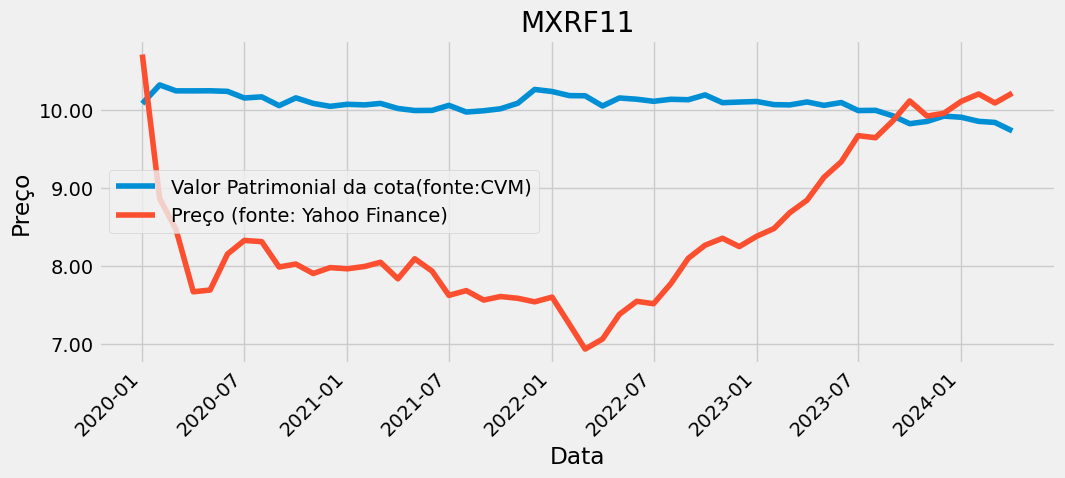

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

"""
Plota os dados de 'Valor_Patrimonial_Cotas' e 'preco' de um fundo imobiliário.
"""

plt.figure(figsize=(11, 4))  # Ajustar o tamanho da figura, se necessário

plt.plot(dados['Data_Referencia'], dados['Valor_Patrimonial_Cotas'], label='Valor Patrimonial da cota(fonte:CVM)')
plt.plot(dados['Data_Referencia'], dados['preco'], label='Preço (fonte: Yahoo Finance)')

plt.xlabel('Data')
plt.ylabel('Preço')
plt.title(fundo.upper())

plt.xticks(rotation=45, ha='right')  # Inclinar os labels do eixo x
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))  # Duas casas decimais no eixo y


plt.grid(True)
plt.legend()
plt.show()

grafico interativo

In [ ]:
import plotly.graph_objects as go
trace1 = go.Scatter( x=dados['Data_Referencia'], y=dados['Valor_Patrimonial_Cotas'],
                     name='Valor Patrimonial da cota (fonte: CVM)', mode='lines')
trace2 = go.Scatter( x=dados['Data_Referencia'], y=dados['preco'],
                     name='Preço (fonte: Yahoo Finance)', mode='lines')
layout = go.Layout(title=fundo.upper(), xaxis=dict( title='Data', tickangle=45 ),
                   yaxis=dict( title='Preço', tickformat='.2f' ),
                   legend=dict(orientation="h" ) )
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [ ]:
dados

,Data_Referencia,Valor_Patrimonial_Cotas,preco
6067,2020-01-01,10.086317,10.717955
6068,2020-02-01,10.327085,8.865845
6069,2020-03-01,10.250717,8.471132
6070,2020-04-01,10.250404,7.666528
6071,2020-05-01,10.251417,7.689299
6072,2020-06-01,10.244206,8.152328
6073,2020-07-01,10.158753,8.326910
6074,2020-08-01,10.173677,8.311728
6075,2020-09-01,10.060672,7.985331
6076,2020-10-01,10.160510,8.023286


In [ ]:
from IPython.display import display, HTML
# Display the HTML table
display(HTML(dados.to_html(index=False)))

Data_Referencia,Valor_Patrimonial_Cotas,preco
2020-01-01,10.086317,10.717955
2020-02-01,10.327085,8.865845
2020-03-01,10.250717,8.471132
2020-04-01,10.250404,7.666528
2020-05-01,10.251417,7.689299
2020-06-01,10.244206,8.152328
2020-07-01,10.158753,8.326910
2020-08-01,10.173677,8.311728
2020-09-01,10.060672,7.985331
2020-10-01,10.160510,8.023286
